# Prediction of tram delays in Cracow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

import xgboost as xgb

import eli5
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

2023-04-06 22:17:01.718134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 22:17:01.901611: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-06 22:17:01.901634: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-06 22:17:02.742311: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
df_1 = pd.read_hdf('tram.1.h5', index_col='id')
df_2 = pd.read_hdf('tram.2.h5', index_col='id')

## Concat datasets and leaving delay columns separated

Concatting `df_train` with ` df_test` and signing it to `df`.

In [3]:
df = pd.concat([df_1,df_2], axis=0)

In [4]:
df.shape

(308152, 11)

In [7]:
df.sample(5)

,id,delay,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num
12595,12595,139.0,78,Batorego,24,Bronowice Małe,2018-07-23 10:20:00,6.352185e+18,6351558574044961030,19.0
249810,249810,367.0,570,Plac Bohaterów Getta,24,Kurdwanów P+R,2018-07-30 16:52:00,6.352185e+18,6351558574044930061,18.0
16951,16951,85.0,61,Bratysławska,50,Krowodrza Górka,2018-07-23 11:58:00,6.352185e+18,6351558574044997900,17.0
205483,205483,59.0,126,Lubicz,52,Czerwone Maki P+R,2018-07-27 16:24:00,6.352185e+18,6351558574046891274,18.0
99036,99036,38.0,2539,Rondo Hipokratesa,14,Bronowice Małe,2018-07-25 07:40:00,6.352185e+18,6351558574044723972,6.0


In [8]:
# Example of a one trip
df[df['trip_id']==6351558574044977929]

,id,delay,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num
120757,120757,0.0,450,Kopiec Wandy,44,Bronowice,2018-07-25 15:58:00,6.352185e+18,6351558574044977929,1.0
121014,121014,102.0,459,Kombinat,44,Bronowice,2018-07-25 16:01:00,6.352185e+18,6351558574044977929,2.0
121235,121235,65.0,423,Struga,44,Bronowice,2018-07-25 16:07:00,6.352185e+18,6351558574044977929,3.0
121415,121415,67.0,2744,Plac Centralny im. R.Reagana,44,Bronowice,2018-07-25 16:11:00,6.352185e+18,6351558574044977929,4.0
121475,121475,83.0,413,Os.Kolorowe,44,Bronowice,2018-07-25 16:12:00,6.352185e+18,6351558574044977929,5.0
121606,121606,21.0,408,Rondo Czyżyńskie,44,Bronowice,2018-07-25 16:16:00,6.352185e+18,6351558574044977929,6.0
121711,121711,29.0,112,Stella-Sawickiego,44,Bronowice,2018-07-25 16:18:00,6.352185e+18,6351558574044977929,8.0
121815,121815,73.0,2811,Muzeum Lotnictwa,44,Bronowice,2018-07-25 16:20:00,6.352185e+18,6351558574044977929,10.0
121889,121889,0.0,3040,TAURON Arena Kraków Wieczysta,44,Bronowice,2018-07-25 16:23:00,6.352185e+18,6351558574044977929,11.0
121946,121946,9.0,130,Białucha,44,Bronowice,2018-07-25 16:24:00,6.352185e+18,6351558574044977929,12.0


Mean: 103.15544925880734
max: 1181.0
min: 0.0
std: 75.71870286403883
Q_1: 46.0
Median: 91.0
Q_3: 152.0
Interquantile range: 106.0


(array([1.91935e+05, 1.06041e+05, 7.74500e+03, 1.65400e+03, 5.21000e+02,
        1.55000e+02, 7.80000e+01, 2.10000e+01, 1.00000e+00, 1.00000e+00]),
 array([   0. ,  118.1,  236.2,  354.3,  472.4,  590.5,  708.6,  826.7,
         944.8, 1062.9, 1181. ]),
 <BarContainer object of 10 artists>)

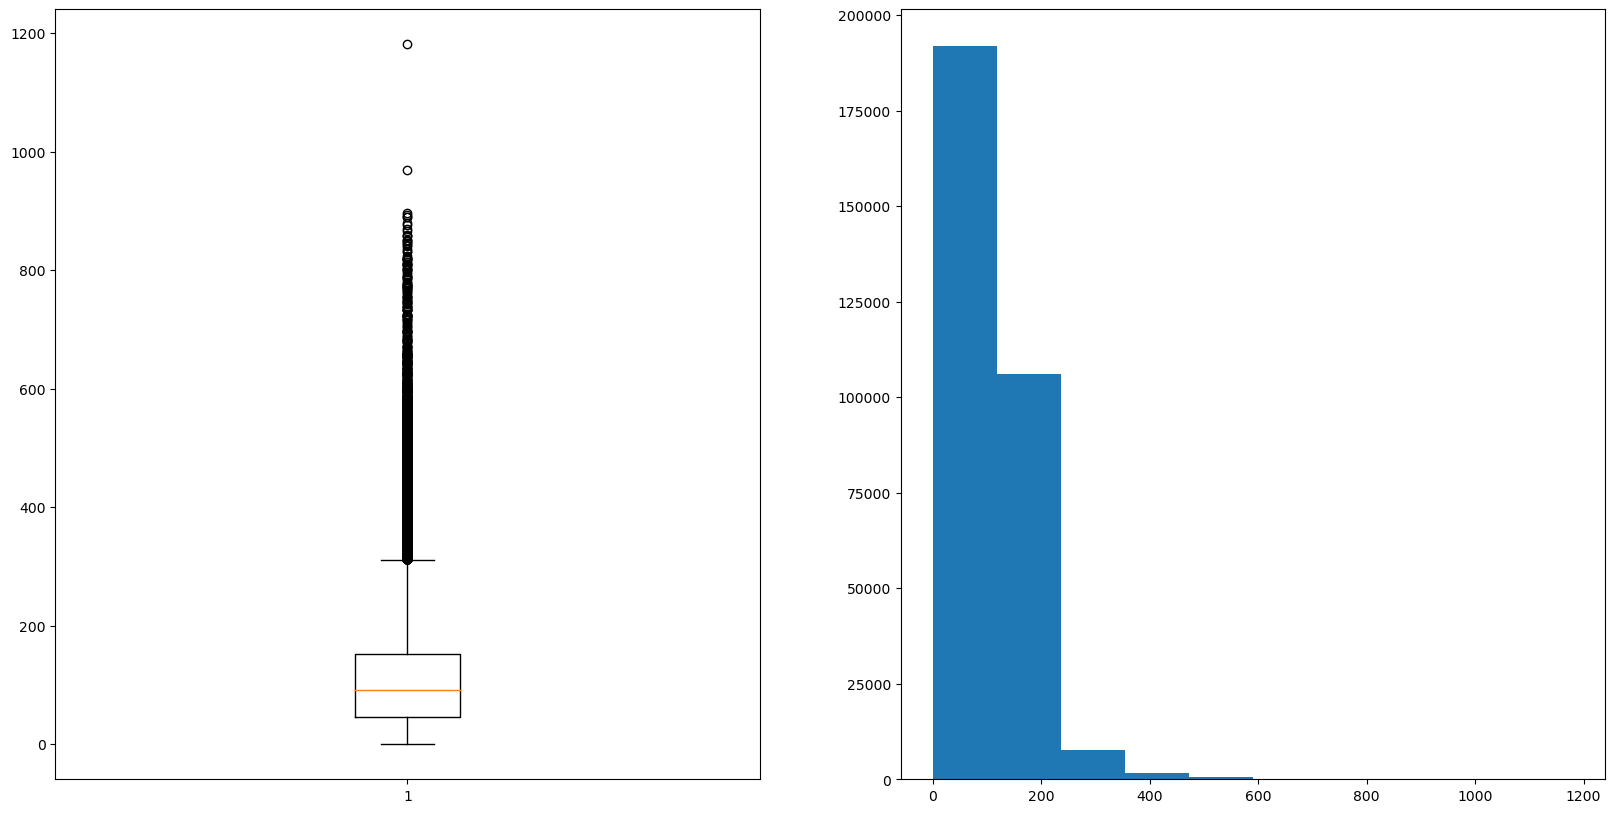

In [10]:
from scipy.stats import iqr
delay = df['delay']
print('Mean: {}'.format(np.mean(delay)))
print('max: {}'.format(np.max(delay)))
print('min: {}'.format(np.min(delay)))
print('std: {}'.format(np.std(delay)))
print('Q_1: {}'.format(np.quantile(delay, .25)))
print('Median: {}'.format(np.quantile(delay, .50)))
print('Q_3: {}'.format(np.quantile(delay, .75)))
print('Interquantile range: {}'.format(iqr(delay)))

fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].boxplot(delay)
axes[1].hist(delay, bins=10)

### Dealing with features (`feature engineering`)

Krakow is one of the largest cities in Poland, which can result in streetcar delays caused by rush hour - when there are longer waits for public transportation.There are different dynamics during for example rush hour.

A hypothesis arises to show the model directly what time it is. <strong> We pull this hour from `planned_time` - the variable tells us what time the planned tram ride was. </strong>

Using `pd.to_datetime` we map planned_time to a datetime type, which allows us to work with dates more easily.

In [11]:
df['planned_time'] = pd.to_datetime(df['planned_time'], format='%Y-%m-%d %H:%M:%S')

df['minute'] = df['planned_time'].dt.minute
df['hour'] = df['planned_time'].dt.hour
df['day'] = df['planned_time'].dt.dayofweek
df['month'] = df['planned_time'].dt.month

df['rush_hours'] = df['hour'].apply(lambda x: 1 if (x > 5 and x < 10) | (x > 14 and x < 19) else 0)
df['night_hours'] = df['hour'].apply(lambda x: 1 if (x < 6 or x > 21) else 0)
df["is_weekend"] = df['day'] > 4

In [72]:
def is_holiday(date):
    if date.month == 7 or (date.month == 8 and date.day <= 31):
        return 1
    elif date.month == 12 and date.day == 25:
        return 1
    elif date == pd.to_datetime(datetime.strftime(date, '%Y')+pd.offsets.EasterSunday()):
        return 1
    elif date.month == 11 and date.day == 1:
        return 1
    else:
        return 0

df['is_holiday'] = df['planned_time'].apply(is_holiday)

df['is_christmas'] = df['planned_time'].apply(lambda x: 1 if (x.month == 12 and x.day == 25) else 0)

df['is_easter'] = df['planned_time'].apply(lambda x: 1 if x == pd.to_datetime(datetime.strftime(x, '%Y')+\
                                                                              pd.offsets.EasterSunday()) else 0)

df['is_wszystkich_swietych'] = df['planned_time'].apply(lambda x: 1 if (x.month == 11 and x.day == 1) else 0)

df['is_new_year'] = df['planned_time'].apply(lambda x: 1 if (x.month == 12 and x.day == 31) else 0)

In [12]:
df['time_diff'] = df['planned_time'].diff()
df['time_diff'] = df['time_diff'].dt.total_seconds()

In [13]:
df['high_seq_num'] = df['seq_num'].map(lambda x: x > 20)

In [14]:
print(len(df['planned_time'].unique()))

# planned_time columns is not needed any more
#I used this column to extract every possible information 
#such as day, month, hour, minute and so on.

df.drop('planned_time', axis=1, inplace=True)

8149


##### Converting object columns into dummies columns

In [15]:
print('Columns with dtype other than numeric: ', df.select_dtypes('object').columns)

Columns with dtype other than numeric:  Index(['stop_name', 'direction'], dtype='object')


In [16]:
print(df['direction'].value_counts(), '\n')
print(len(df['direction'].unique()))

direction = pd.get_dummies(df['direction'], prefix = 'direction', drop_first=True)
df.drop('direction', axis=1, inplace=True)

df = pd.concat([df,direction], axis=1)

Czerwone Maki P+R    36743
Bronowice Małe       35937
Krowodrza Górka      35372
Nowy Bieżanów P+R    22648
Wzgórza K.           22416
Borek Fałęcki        18488
Kurdwanów P+R        18293
Os.Piastów           18169
Salwator             16224
Mistrzejowice        15089
Mały Płaszów         13517
Bronowice            10259
Prokocim              9296
Kopiec Wandy          7965
Cichy Kącik           7480
Walcownia             6276
Łagiewniki            5410
Dworzec Tow.          5393
Cm. Rakowicki         1788
Kombinat              1389
Name: direction, dtype: int64 

20


In [17]:
print(df['stop_name'].value_counts(), '\n')
print(len(df['stop_name'].unique()))

stop_name = pd.get_dummies(df['stop_name'], prefix = 'stop_name', drop_first=True)
df.drop('stop_name', axis=1, inplace=True)

Rondo Mogilskie                            6766
Dworzec Główny                             6699
Stradom                                    5062
Rondo Grzegórzeckie                        5004
Kabel                                      4800
Starowiślna                                4755
Rondo Czyżyńskie                           4516
Bieżanowska                                4318
Podgórze SKA                               4315
Teatr Bagatela                             4289
Stary Kleparz                              4131
Poczta Główna                              4131
Lubicz                                     4126
Dworzec Towarowy                           3722
Dworcowa                                   3674
Filharmonia                                3592
Korona                                     3571
Cmentarz Podgórski                         3564
Biprostal                                  3515
Bratysławska                               3454
Plac Wszystkich Świętych                

## Dealing with NaN Values

['seq_num', 'time_diff']


<AxesSubplot:>

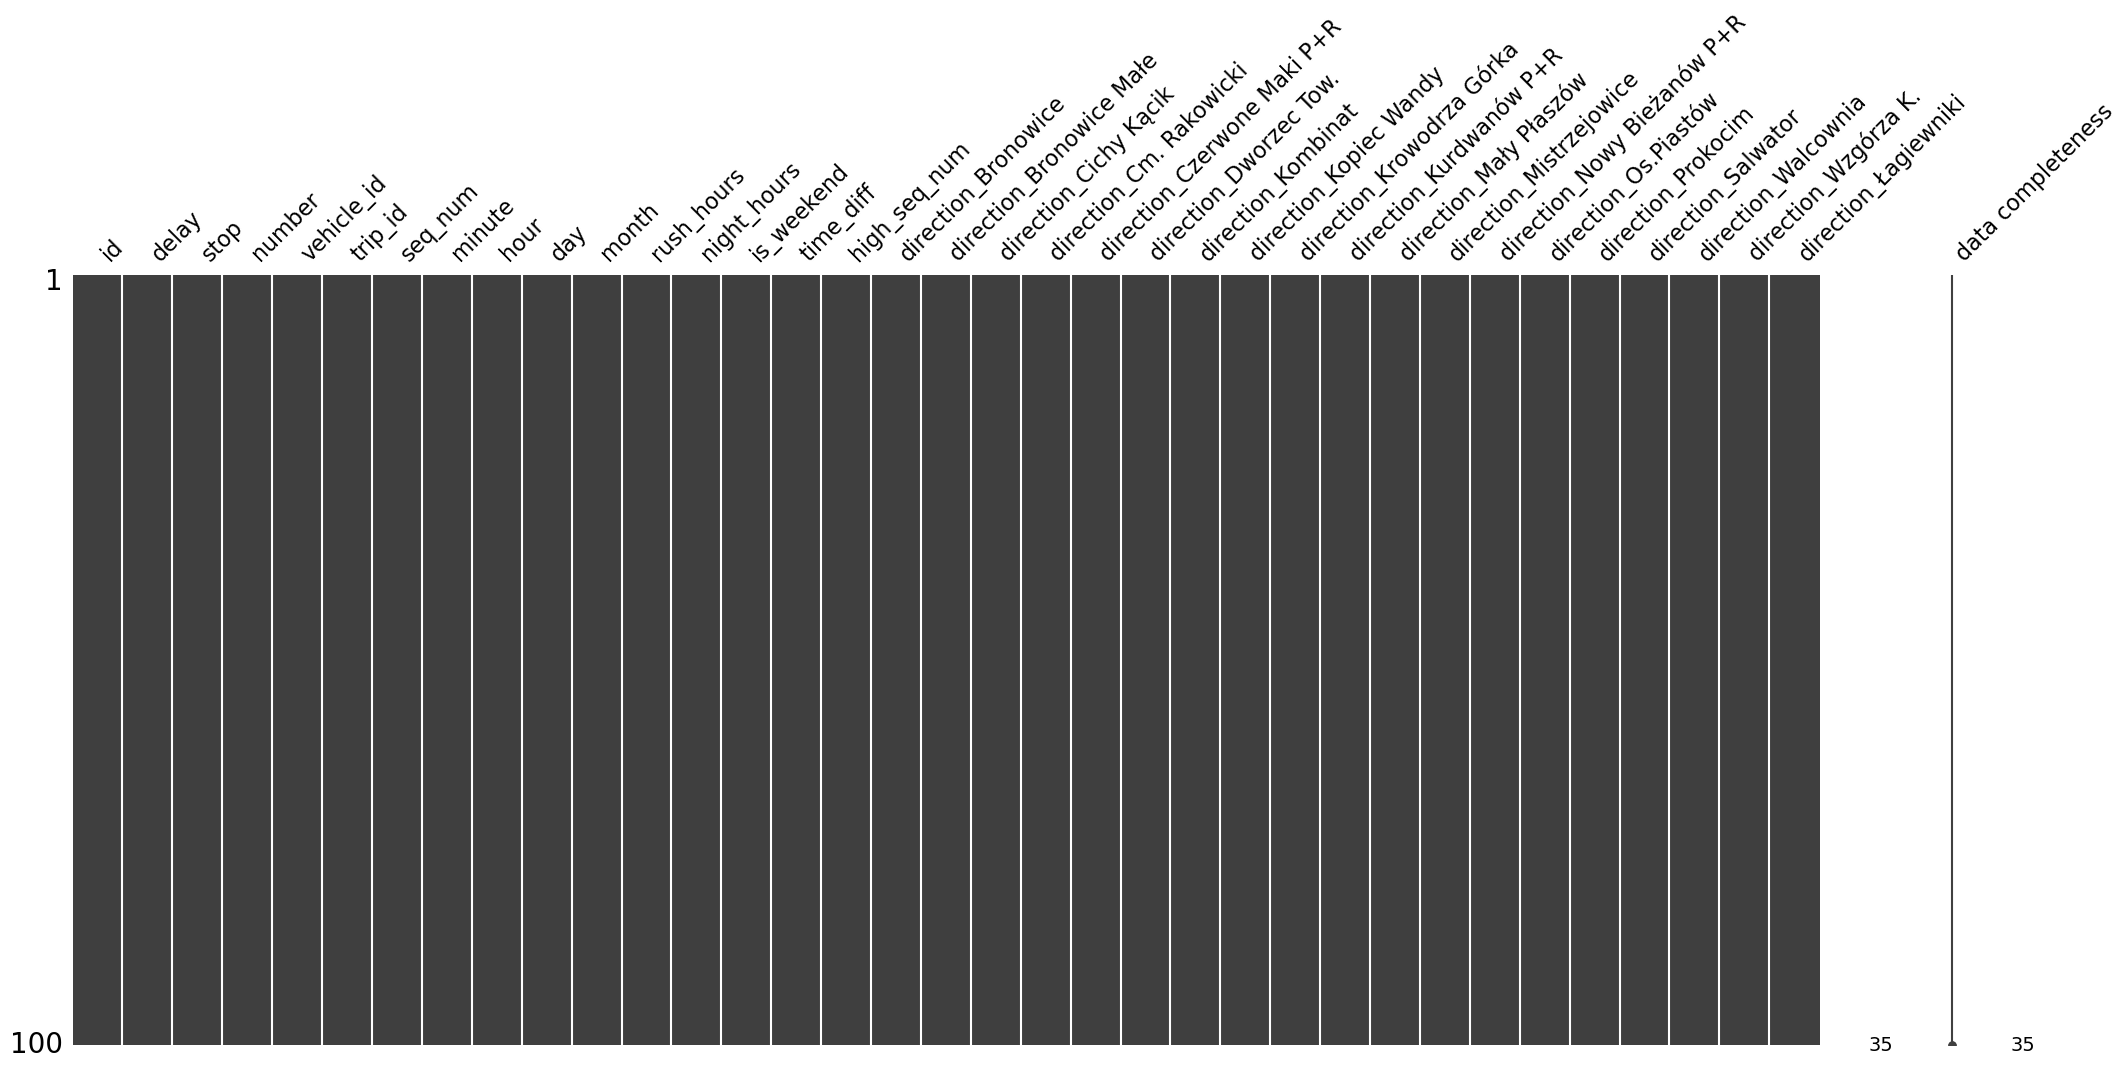

In [18]:
import missingno as msno

print(df.columns[df.isna().any()].tolist())
msno.matrix(df.sample(100), labels=True)

In [19]:
df['seq_num'] = df['seq_num'].interpolate()

In [21]:
df['time_diff'] = df['time_diff'].fillna(0)

In [22]:
print(df.columns[df.isna().any()].tolist())
print(df.info())

[]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 308152 entries, 0 to 308145
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           308152 non-null  int64  
 1   delay                        308152 non-null  float64
 2   stop                         308152 non-null  int64  
 3   number                       308152 non-null  int64  
 4   vehicle_id                   308152 non-null  float64
 5   trip_id                      308152 non-null  int64  
 6   seq_num                      308152 non-null  float64
 7   minute                       308152 non-null  int64  
 8   hour                         308152 non-null  int64  
 9   day                          308152 non-null  int64  
 10  month                        308152 non-null  int64  
 11  rush_hours                   308152 non-null  int64  
 12  night_hours                  308152 non-null  int64  
 

## Select features

In addition, we can ignore some features, because if you check them more carefully, it turns out that they do not contribute much.

In [25]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df_numeric = df[numeric_cols]

X, y = df_numeric.drop('delay', axis=1), df['delay']

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,\
                                                  test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Building the model

<strong>Due to the large amount of data/records, most of the models available in scikit-learn will not be able to learn the model!</strong> For that, we can still use the capabilities of the XGBoost library.

##### Creating first models

In [60]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
y_pred_val = dt.predict(X_val)

print('RMSE on train dataset: {}'.format(mean_squared_error(y_train,y_pred_train, squared=False)))
print('RMSE on test dataset: {}'.format(mean_squared_error(y_test,y_pred_test, squared=False)))
print('RMSE on val dataset: {}'.format(mean_squared_error(y_val,y_pred_val, squared=False)))

RMSE on train dataset: 69.7253791109406895
RMSE on test dataset: 74.285308148311886
RMSE on val dataset: 76.537918148109426


In [62]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)
y_pred_val = rfr.predict(X_val)

print('RMSE on train dataset: {}'.format(mean_squared_error(y_train,y_pred_train, squared=False)))
print('RMSE on test dataset: {}'.format(mean_squared_error(y_test,y_pred_test, squared=False)))
print('RMSE on val dataset: {}'.format(mean_squared_error(y_val,y_pred_val, squared=False)))

RMSE on train dataset: 66.1425802693403796
RMSE on test dataset: 73.419064559111888
RMSE on val dataset: 77.284258148309486


In [63]:
from sklearn.ensemble import BaggingRegressor

br = BaggingRegressor(base_estimator=tr,
                     oob_score=True #scoring on unused values
                     )

br.fit(X_train,y_train)

y_pred_train = br.predict(X_train)
y_pred_test = br.predict(X_test)
y_pred_val = br.predict(X_val)

print('RMSE on train dataset: {}'.format(mean_squared_error(y_train,y_pred_train, squared=False)))
print('RMSE on test dataset: {}'.format(mean_squared_error(y_test,y_pred_test, squared=False)))
print('RMSE on val dataset: {}'.format(mean_squared_error(y_val,y_pred_val, squared=False)))

RMSE on train dataset: 64.1749234905406895
RMSE on test dataset: 77.092853506511886
RMSE on val dataset: 79.2379814832693803


In [70]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_r = GradientBoostingRegressor()

gradient_r.fit(X_train,y_train)

y_pred_train = gradient_r.predict(X_train)
y_pred_test = gradient_r.predict(X_test)
y_pred_val = gradient_r.predict(X_val)

print('RMSE on train dataset: {}'.format(mean_squared_error(y_train,y_pred_train, squared=False)))
print('RMSE on test dataset: {}'.format(mean_squared_error(y_test,y_pred_test, squared=False)))
print('RMSE on val dataset: {}'.format(mean_squared_error(y_val,y_pred_val, squared=False)))

RMSE on train dataset: 51.801767327665566
RMSE on test dataset: 52.79320504642763
RMSE on val dataset: 53.84402422466259


In [65]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)
y_pred_val = xgb_model.predict(X_val)

print('RMSE on train dataset: {}'.format(mean_squared_error(y_train,y_pred_train, squared=False)))
print('RMSE on test dataset: {}'.format(mean_squared_error(y_test,y_pred_test, squared=False)))
print('RMSE on val dataset: {}'.format(mean_squared_error(y_val,y_pred_val, squared=False)))

RMSE on train dataset: 46.967036084927784
RMSE on test dataset: 48.327359791570004
RMSE on val dataset: 50.28530670314252


##### Hyperparameter tuning on the XGBRegressor

In [38]:
from sklearn.model_selection import RandomizedSearchCV, KFold

kf = KFold(n_splits=10, shuffle=True, random_state=123)

params_xgbr = {'gamma': np.linspace(0.3,0.6,7),
              'learning_rate': np.linspace(0.1,0.3,8),
              'max_depth': [5,6,7,8],
              'n_estimators': np.arange(85,110,5),
              'reg_alpha': np.linspace(0.6,0.9,6),
              'reg_lambda': np.linspace(0.7,0.9,6)}

In [67]:
xgbr = xgb.XGBRegressor()

xgbr_rs = RandomizedSearchCV(xgbr, params_xgbr, cv=kf, n_jobs=-1)
xgbr_rs.fit(X_train,y_train)

y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)
y_pred_val = xgb_model.predict(X_val)

print('Best params: ', xgbr_rs.best_params_)
print('RMSE on train dataset: {}'.format(mean_squared_error(y_train,y_pred_train, squared=False)))
print('RMSE on test dataset: {}'.format(mean_squared_error(y_test,y_pred_test, squared=False)))
print('RMSE on val dataset: {}'.format(mean_squared_error(y_val,y_pred_val, squared=False)))

Best params: {'reg_lambda': 0.8200000000000001, 'reg_alpha': 0.9, 'n_estimators': 85, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.5499999999999999}
RMSE on train dataset: 34.967036084927784
RMSE on test dataset: 38.327359791570004
RMSE on val dataset: 37.747008148393401


##### Cross validation on the XGBRegressor

In [68]:
from sklearn.model_selection import cross_val_score

xgbr_hp = xgbr_rs.best_estimator_ 

scores = cross_val_score(xgbr_hp, X_train, y_train, cv=40, scoring="neg_mean_squared_error")

print('mean of cross validation: {}'.format(np.sqrt(-scores.mean())))
print('std of cross validation: {}'.format(scores.std()))

mean of cross validation: 38.462089456203035
std of cross validation: 0.06042392804400001


##### Save model

In [69]:
import pickle
file_name = "xgbr_hp.pkl"

# save
pickle.dump(xgbr_hp, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))